In [1]:
suppressWarnings(suppressMessages(library(tidyverse))) # ggplot and dplyr
suppressWarnings(suppressMessages(library(reshape2))) # melt
suppressWarnings(suppressMessages(library(VIM))) # KNN imputation
suppressWarnings(suppressMessages(library(Hmisc))) # univariate
suppressWarnings(suppressMessages(library(RColorBrewer))) # color palletes
suppressWarnings(suppressMessages(library(ggExtra))) # ggMarginal (combine boxplot with distribution
suppressWarnings(suppressMessages(library(gridExtra))) #Aggregate plots
suppressWarnings(suppressMessages(library(grid))) #textGrob for gridArrange
suppressWarnings(suppressMessages(library(ggpubr))) #ALTERNATIVE to gridArrange with common legend for plots
suppressWarnings(suppressMessages(library(moments))) # Skewness and kurtosis

In [78]:
getRversion()

[1] '3.6.3'

In [10]:
# Help Functions

# Plot boxplot of a variable (col) in a dataset (df).
# Shown without axis to blend in with the complete univariate analysis.
plot_univariate_boxplot = function(df, col, var_name = "Health expenditure as percentage of GDP") {
    p2 = df %>% ggplot(aes_string(col)) +
        geom_boxplot(lwd = 0.7, fill = "grey", alpha = 0.5) +
        scale_x_continuous(limits = c(min(df[col]), max(df[col]))) +
        theme_classic() +
        theme(text = element_text(size = 17), axis.text=element_blank(), axis.ticks = element_blank(), axis.title.y = element_blank(), panel.background = element_blank(), axis.line = element_blank()) + 
        labs(x = var_name)
    
    return(p2)
}

# Plot distribution histogram of a variable (col) in a dataset (df).
# Shows mean, median, skewness and kurtosis as well as its density curve.
plot_distribution_univariate = function(df, col, bin_width = 0.5, var_name = "Health expenditure as percentage of GDP") {
    mean_col = round(mean(df[, col]), 2); median_col = round(median(df[, col]), 2)
    skewness = round(skewness(df[, col]), 2); kurtosis = round(kurtosis(df[, col]), 2)
    
    p1 = df %>% ggplot(aes_string(col)) +
        geom_histogram(aes(y = ..density..), color = "black", fill = "grey", alpha = 0.5, binwidth = bin_width) +
        geom_density(aes(color = "Density curve"), size = 1) +
        geom_vline(aes(xintercept = mean_col, color = paste("mean =", mean_col)), lwd = 1.5) + 
        geom_vline(aes(xintercept = median_col, color = paste("median =", median_col)), lwd = 1.5) +
        scale_x_continuous(breaks = round(seq(min(df[col]), max(df[col]), (max(df[col]) - min(df[col])) / 15), 1), limits = c(min(df[col]), max(df[col]))) +
        scale_color_brewer(name = "", palette = "Set1") +
        labs(title = paste("Distribution of", var_name), x = NULL, y = "Percentage of countries", 
            subtitle = paste('Skewness =', skewness, '    Kurtosis =', kurtosis)) +
        theme(text = element_text(size = 17), plot.title = element_text(size = 20, face = "bold", hjust = 0.5, color = "royalblue"),
             plot.subtitle = element_text(size = 17, hjust = 0.5))
    
    return(p1)
}

# Plot a complete univariate analysis plot of a variable (col) in a dataset (df).
# Shows complete dataset vs. no outliers - using interquartile range to remove the outliers.
plot_univariate_analysis = function(df, col = "Health_exp_pct_of_GDP", bin_width = 0.5, var_name = "Health expenditure as percentage of GDP", plot.width = 15, plot.height = 10) {
    options(repr.plot.width = plot.width, repr.plot.height = plot.height)
    
    # Describe data - contains the quartiles
    desc_data = sapply(describe(df[[col]])$counts, as.double)
    
    # Interquartile range - to remove outliers
    pos_thresh = desc_data['.50'] + 1.5 * (desc_data['.75'] - desc_data['.25'])
    neg_thresh = desc_data['.50'] - 1.5 * (desc_data['.75'] - desc_data['.25'])
    
    # Remove outliers - using interquartile range
    data_no_outliers = df[col][(df[col] > neg_thresh) & (df[col] < pos_thresh)]
    data_no_outliers = as.data.frame(data_no_outliers)
    
    # Plot figures - boxplots and distributions
    p1 = plot_distribution_univariate(data_no_outliers, col = colnames(data_no_outliers)[1], bin_width = bin_width, var_name = paste(var_name, "(without outliers)"))
    p2 = plot_univariate_boxplot(data_no_outliers, col = colnames(data_no_outliers)[1], var_name = var_name)
    p3 = plot_distribution_univariate(df, col = col, bin_width = bin_width, var_name = paste(var_name, "(complete)"))
    p4 = plot_univariate_boxplot(df, col = col, var_name = var_name)
    
    # Aggregate plots in a single figure - small boxplot and large histogram
    fig = suppressWarnings(ggarrange(p3, p1, p4, p2, nrow = 2, ncol = 2,  legend = "bottom", align = "v", heights = c(3.5, 0.5))) #one common legend between the plots
    return(fig)
}

# EAD - Assignment2
## Health systems -> How do each country's health indicators influence the growth of covid cases, tests and deaths?

Vasco Campos -> up201908482

Bruno Reis -> up201908682

__Estatística e Análise de dados__, June 2020

# Introduction
blah blah blah

# Datasets: adding predictor and target variables
The main dataset contains some health system indicators for each country in the world, but lacks target variables and some descriptive variables like the population of the country for example or its continent.

## World bank health systems
__What does each column mean?__
1. __Country__: the region as used in Kaggle Covid-19 spread data challenges.
2. __Province__: the region as used in Kaggle Covid-19 spread data challenges.
3. __Bank_Name__: the name of the country used by the World Bank
4. __Health_exp_pct_of_GDP__: Level of current health expenditure expressed as a percentage of GDP. Estimates of current health expenditures include healthcare goods and services consumed during each year. This indicator does not include capital health expenditures such as buildings, machinery, IT and stocks of vaccines for emergency or outbreaks.
5. __Health_exp_funded_by_public__: Share of current health expenditures funded from domestic public sources for health. Domestic public sources include domestic revenue as internal transfers and grants, transfers, subsidies to voluntary health insurance beneficiaries, non-profit institutions serving households (NPISH) or enterprise financing schemes as well as compulsory prepayment and social health insurance contributions. They do not include external resources spent by governments on health.
6. __Health_exp_funded_by_household__: Share of out-of-pocket payments of total current health expenditures. Out-of-pocket payments are spending on health directly out-of-pocket by households.
7. __Health_exp_percapita_USD__: Current expenditures on health per capita in current US dollars. Estimates of current health expenditures include healthcare goods and services consumed during each year.
8. __Health_exp_percapita_PPP__: Current expenditures on health per capita expressed in international dollars at purchasing power parity (PPP).
9. __Health_exp_pct_funded_by_externals__: Share of current health expenditures funded from external sources. External sources compose of direct foreign transfers and foreign transfers distributed by government encompassing all financial inflows into the national health system from outside the country. External sources either flow through the government scheme or are channeled through non-governmental organizations or other schemes.
10. __Physicians_per_1000__: Physicians include generalist and specialist medical practitioners.
11. __Nurses_per_1000__: Nurses and midwives include professional nurses, professional midwives, auxiliary nurses, auxiliary midwives, enrolled nurses, enrolled midwives and other associated personnel, such as dental nurses and primary care nurses.
12. __Specialist_surgical_per_100000__: Specialist surgical workforce is the number of specialist surgical, anaesthetic, and obstetric (SAO) providers who are working in each country per 100,000 population.
13. __Birth_reg_pct__: Completeness of birth registration is the percentage of children under age 5 whose births were registered at the time of the survey. The numerator of completeness of birth registration includes children whose birth certificate was seen by the interviewer or whose mother or caretaker says the birth has been registered.
14. __Death_reg_pct__: Completeness of death registration is the estimated percentage of deaths that are registered with their cause of death information in the vital registration system of a country.

In [3]:
df = read_csv("2.12_Health_systems.csv", col_types = c("cccddddddddddd"))
colnames(df) = c("Country", "Province", "Bank_Name", "Health_exp_pct_of_GDP", "Health_exp_funded_by_public", "Health_exp_funded_by_household", "Health_exp_percapita_USD", 
                "Health_exp_percapita_PPP", "Health_exp_pct_funded_by_externals", "Physicians_per_1000", "Nurses_per_1000", "Specialist_surgical_per_100000", "Birth_reg_pct", "Death_reg_pct")
head(df)

Country,Province,Bank_Name,Health_exp_pct_of_GDP,Health_exp_funded_by_public,Health_exp_funded_by_household,Health_exp_percapita_USD,Health_exp_percapita_PPP,Health_exp_pct_funded_by_externals,Physicians_per_1000,Nurses_per_1000,Specialist_surgical_per_100000,Birth_reg_pct,Death_reg_pct
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Afghanistan,NA,Afghanistan,10.2,5.1,77.4,57.2,162.8,17.5,0.3,0.3,0.0,42.3,NaN
Albania,NA,Albania,6.7,41.4,58.0,271.5,759.7,0.7,1.2,3.6,11.6,98.4,53
Algeria,NA,Algeria,6.6,67.7,30.9,260.4,998.2,0.0,1.8,2.2,12.1,100.0,NaN
Andorra,NA,Andorra,10.4,49.1,41.7,3834.7,4978.7,NaN,3.3,4.0,83.1,100.0,80
Angola,NA,Angola,2.9,44.1,35.2,95.2,185.8,3.6,0.2,1.3,NaN,25.0,NaN
Antigua and Barbuda,NA,Antigua and Barbuda,4.3,60.6,32.2,623.1,976.4,0.0,2.8,3.1,14.0,NaN,79


# PreProcessing
## Removing NANs
First, we check how many nans are in each column of the dataset.

Province has a lot of NA values, because it only contains the provinces of countries and is NA when the country has no province.

In [4]:
cat("percentage of missing values in the entire dataset:", mean(is.na(df) * 100), "%\n")
print(colMeans(is.na(df)))

percentage of missing values in the entire dataset: 20.71429 %
                           Country                           Province 
                         0.1095238                          0.9333333 
                         Bank_Name              Health_exp_pct_of_GDP 
                         0.0000000                          0.1142857 
       Health_exp_funded_by_public     Health_exp_funded_by_household 
                         0.1142857                          0.1142857 
          Health_exp_percapita_USD           Health_exp_percapita_PPP 
                         0.1142857                          0.1142857 
Health_exp_pct_funded_by_externals                Physicians_per_1000 
                         0.2047619                          0.1000000 
                   Nurses_per_1000     Specialist_surgical_per_100000 
                         0.1000000                          0.1666667 
                     Birth_reg_pct                      Death_reg_pct 
              

We decide to remove the variables _Country_ and _Province_, because of the NAs and because the Country variable is only an id for each observation, therefore it has no real information to give us.

The _Death_reg_pct_ is removed due to a high number of NAs and because it would not be viable to impute such a large number of values.

In [5]:
df = df[, !names(df) %in% c("Country", "Province", "Death_reg_pct")]

__Removing all observations that have three or more null values__

This way, most null values are eliminated in an efficient way that also removes the observations with less information available.

In [6]:
df$na_count <- apply(is.na(df), 1, sum)
df = df[(df[,"na_count"]<=3),]

In [7]:
cat("Percentage of missing values in dataset after removing observation with 3 or more NA values:", mean(is.na(df)) * 100, "%")

Percentage of missing values in dataset after removing observation with 3 or more NA values: 3.181004 %

### KNN imputation
The remaining __3.18%__ of missing values in the dataset are dealt with using the KNN imputation technique. This way, we are able to impute values into observations based on the median of their 5 nearest neighbors.

In [8]:
imputed_data = kNN(df[, 2:11], imp_var = FALSE, useImputedDist = FALSE)
imputed_data$Bank_Name = df$Bank_Name
cat("Percentage of missing values after KNN imputation:", mean(is.na(imputed_data)), "%")

Percentage of missing values after KNN imputation: 0 %

As we can see, the final percentage of missing values is __0%__, meaning our data is ready to be explored.

# Univariate analysis

In this section of the report, we will perform univariate analysis of every variable in our dataset. Every variable will have two different datasets to compare, one __complete__ and one __without outliers__. The outliers are identified and removed using the __inter quantile difference__ between the 75% and the 25% quantiles as threshold. The measures of __centrality__ are shown, such as the __mean__ and the __median__, as well as the measures of __spread__, such as the __skweness__ and the __kurtosis__.

The distribution histograms show the density of values in the variable as well as its density curve and below each histogram the boxplot of the data is shown in order to show the distribution in a different way, exposing more the outlier points and the location of the quartiles in the data.

One important note to mention is that, altough our data has some outliers those values do __not__ correspond to __wrong values__, but rather to countries that are different from the normal paradigm (like Monaco, or Luxembourg). Taking this into account, there is no real reason to remove this outliers other than statistical analysis, which exactly what we do in this section of the report. 

There are a few main objectives to extract from exploring all of these plots:
* Observe how the values of a variable are distributed and whether it has outliers or not.
* Observe the changes in themean and the median when the outliers are removed.
* Observe the changes in the spread of the data when the outliers are removed and observe if that has an impact on the approximation of the distribution to a normal distribution.

#### 1. Health expenditures as a percentage of the GDP of a country
Show the percentage of a country GDP that is used to finance health expenses. It is an indicator of how much a country is willing to spend for the beneficts of a better public health system.

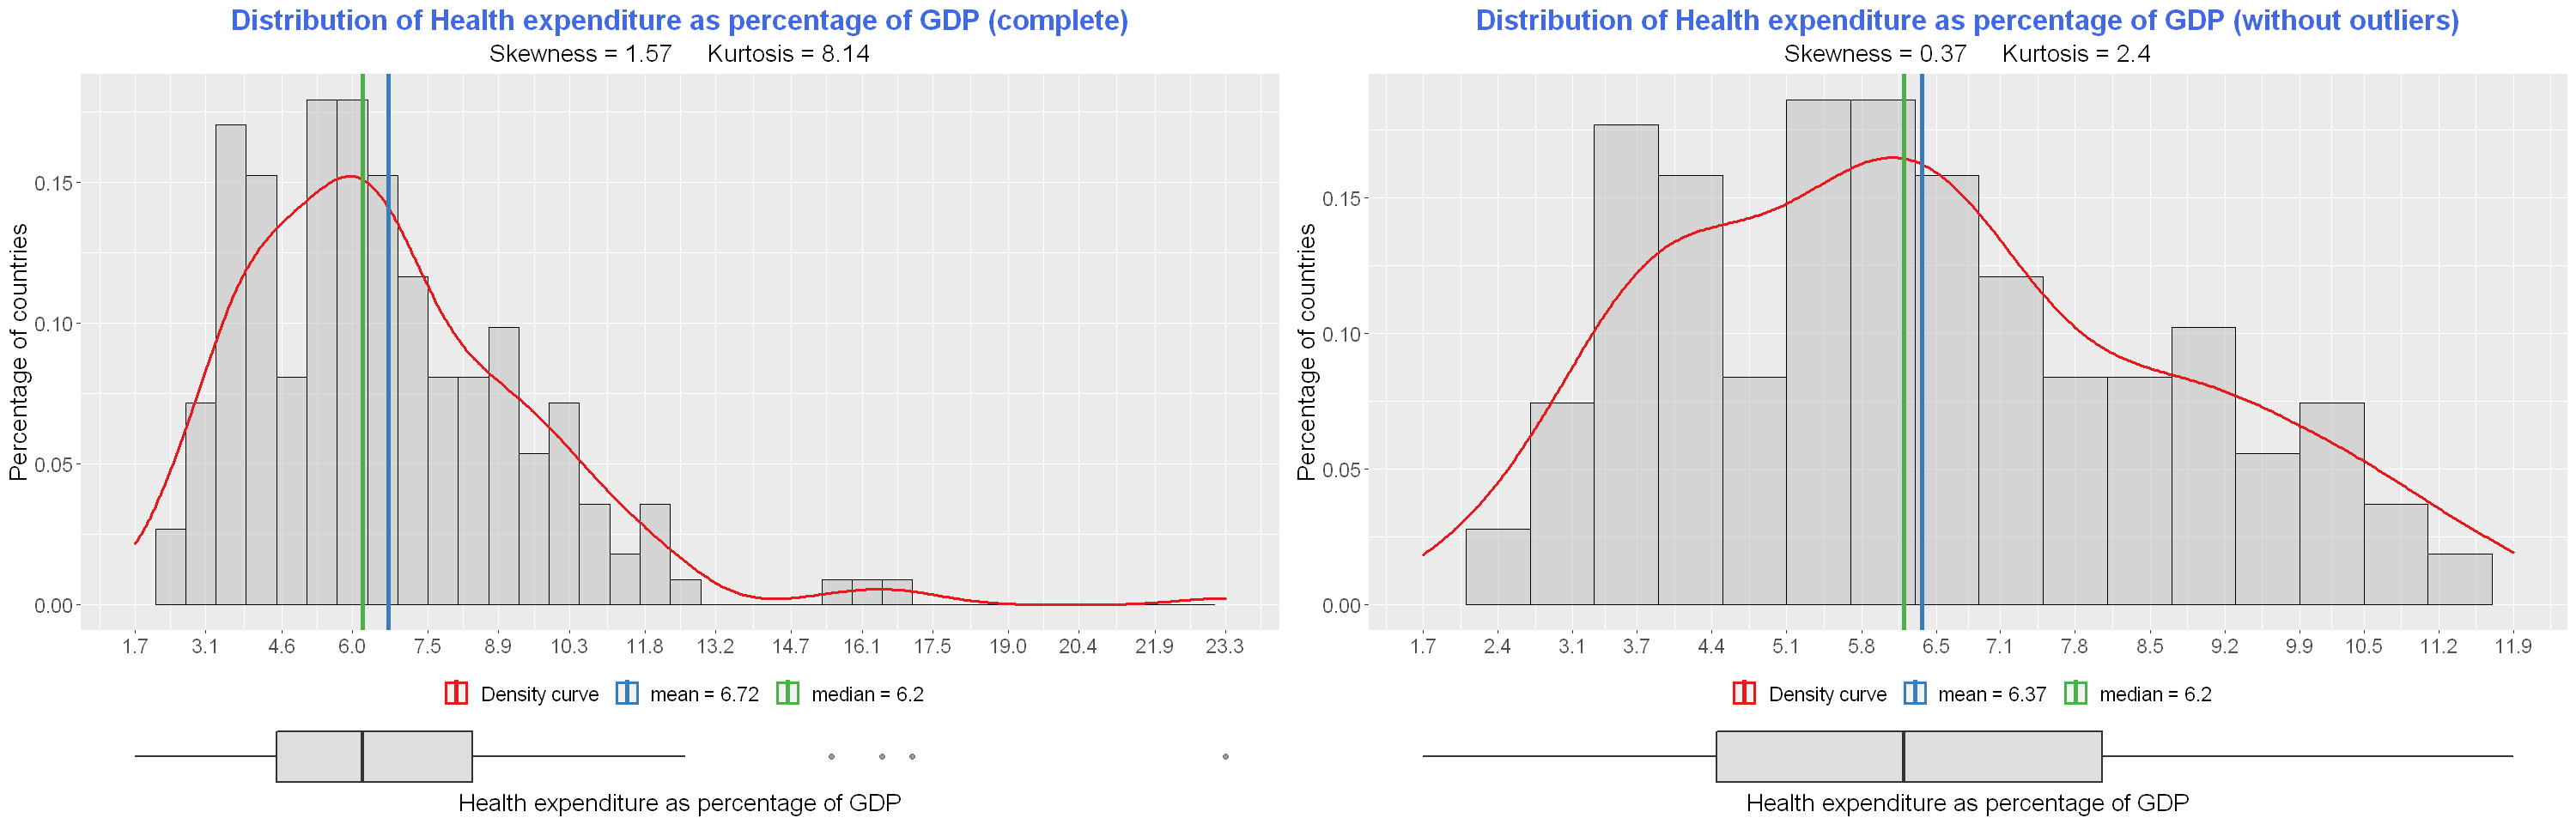

In [11]:
plot_univariate_analysis(imputed_data, col = "Health_exp_pct_of_GDP", bin_width = 0.6, var_name = "Health expenditure as percentage of GDP", plot.width = 25, plot.height = 8)

The __plots on the left__ show that the distribution of this variable contains a few outliers (shown by the dots in the boxplot). However this outliers do not seem to have a big impact on the mean, since it is fairly close to the median value. 

The high values of the __kurtosis__ and of the __skewness__ in the __left plots__ also show the existence of this outliers and how the data is slightly skewed to the left. Furthermore, they also show that the distribution is __not normal__.

The __plots on the right__ show a distribution much closer to the __normal one__. The skewness is much softer (close to 0) and the kurtosis goes from 8.14 to 2.4. The boxplot also shows that there are no more outliers.

In conclusion, the few countries that are outliers in this variable skew the results quite a bit, so removing them causes the distribution to normalize. We can also see that most countries spend __between 3% to 10%__ of their GDP in healthcare expenses, which shows that __all around the world__ healthcare concerns are taken seriously.

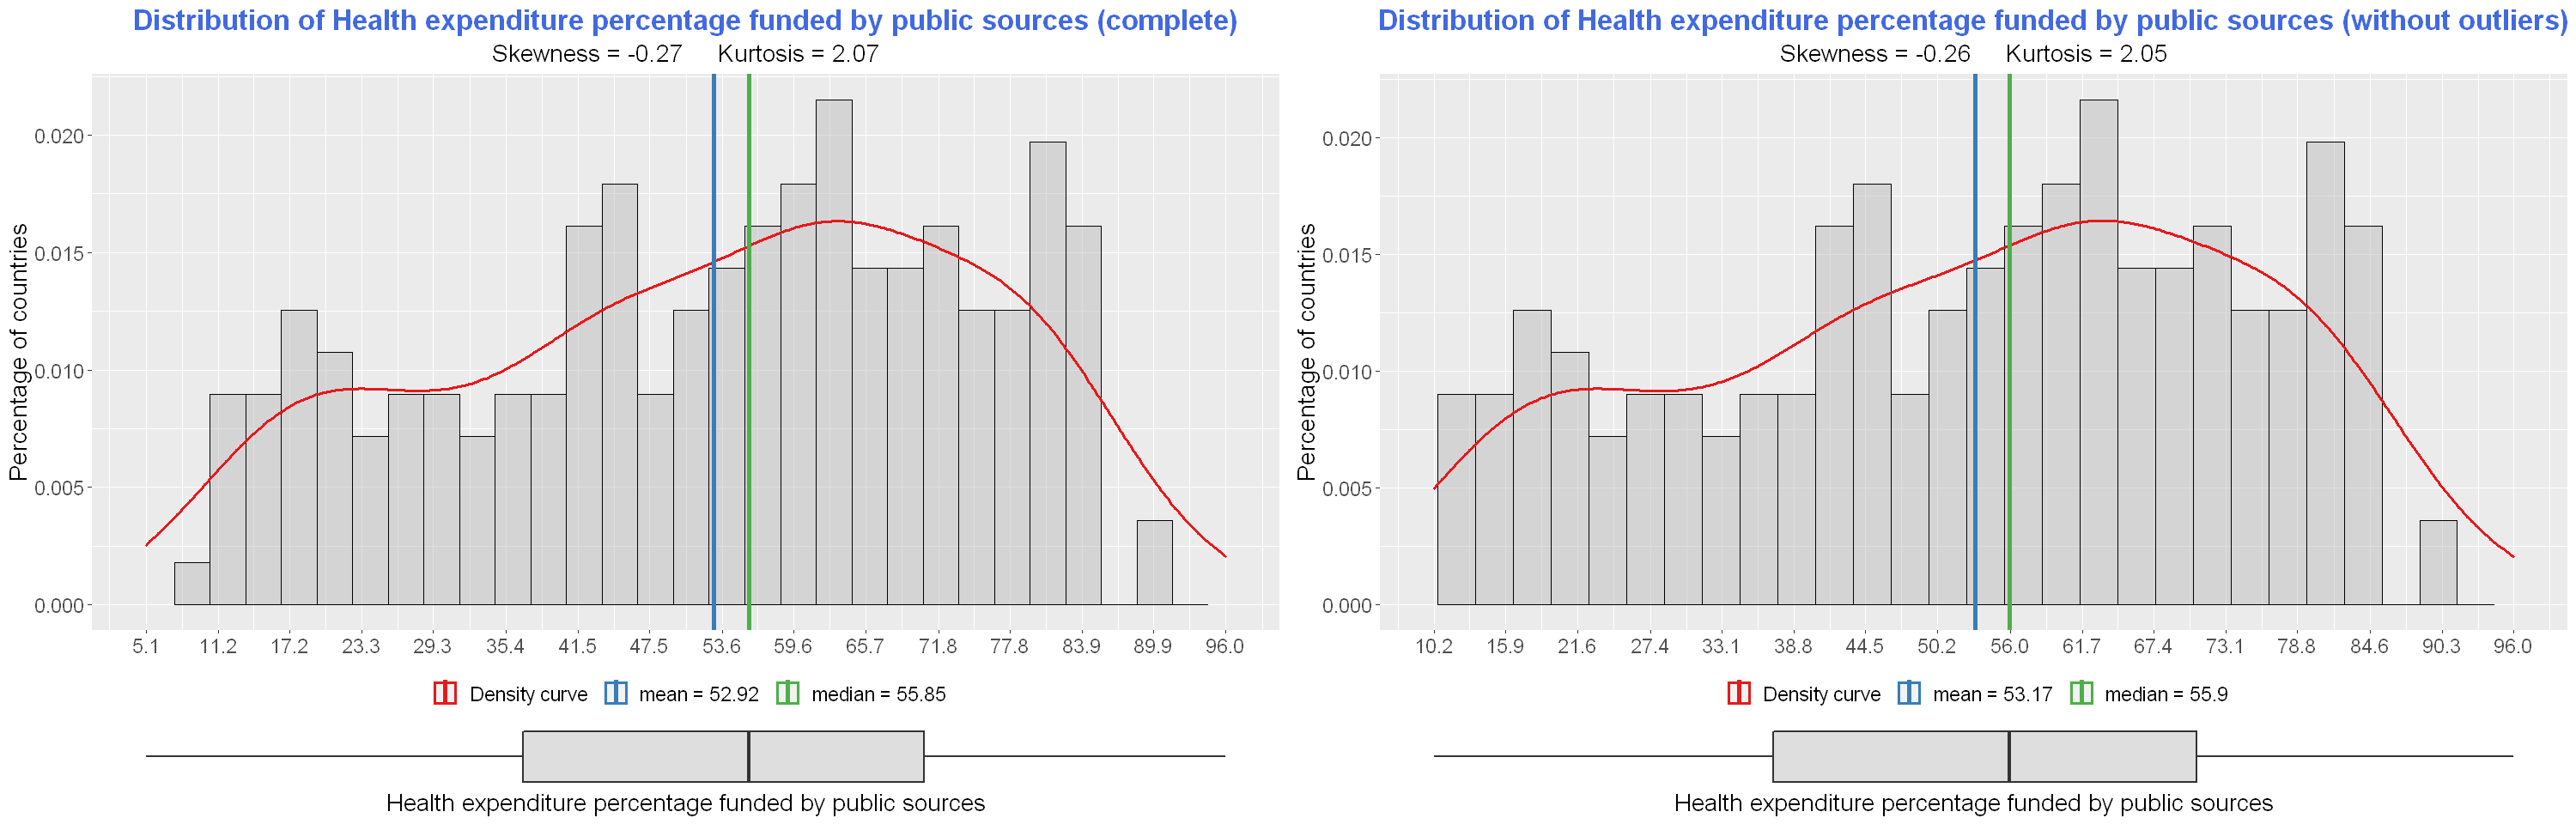

In [12]:
plot_univariate_analysis(imputed_data, col = "Health_exp_funded_by_public", bin_width = 3, var_name = "Health expenditure percentage funded by public sources", plot.width = 25, plot.height = 8)

This variables has a much different distribution compared to the first one:
* The boxplot on the left show __no outliers__ even before removing outlier values.
* Comparing the mean and median on both sides, we can see that there is almost no difference between the values, which means this variable is very evenly distributed.
* The kurtosis and skewness remain pratically the same after removing outliers, which further proves the even distribution of this variable.
* In conclusion, the values of this variables range mostly between __10 and 84%__, which means that the health expenditure percentage covered by public funds (insurances, etc.) __varies a lot__ depending on the country, there is no established norm.

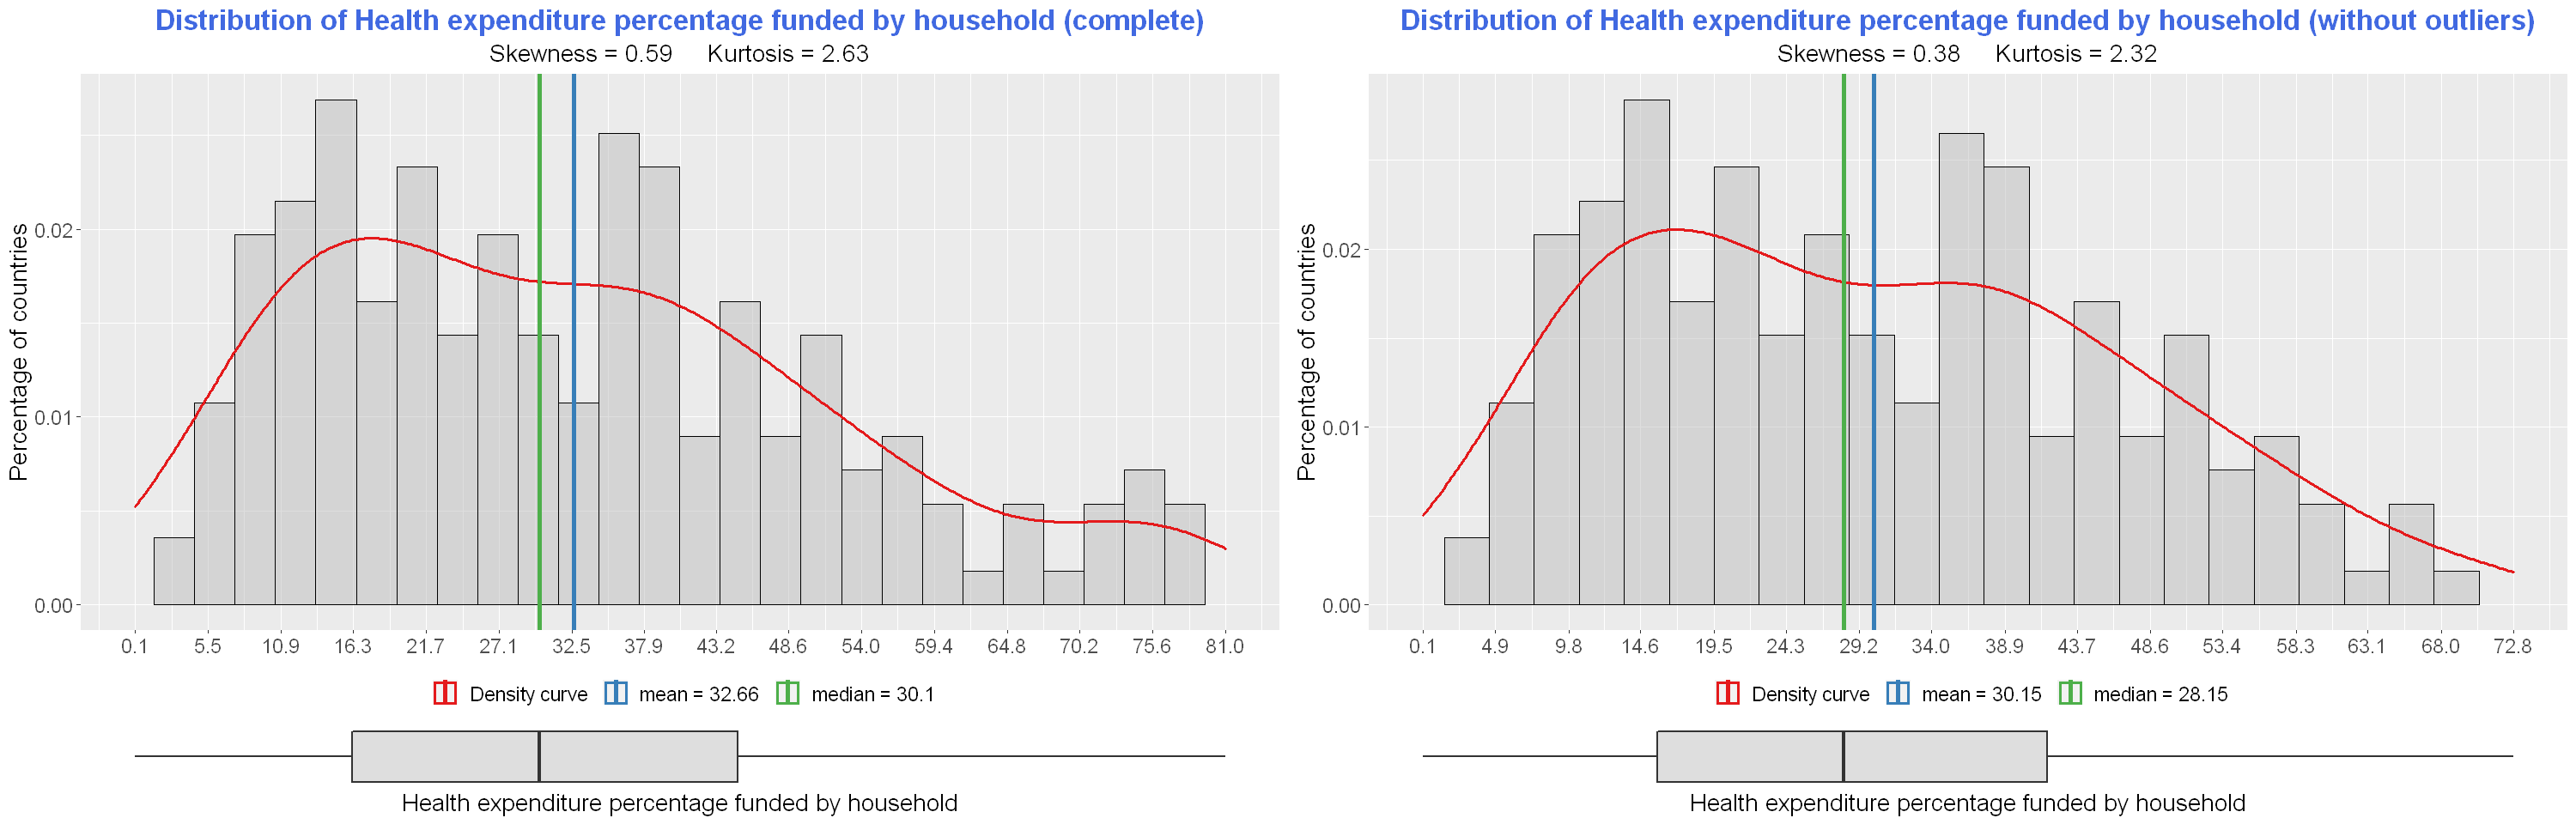

In [13]:
plot_univariate_analysis(imputed_data, col = "Health_exp_funded_by_household", bin_width = 3, var_name = "Health expenditure percentage funded by household", plot.width = 25, plot.height = 8)

The distribution of this variable is very similar to the one above:
* Values are very evenly distributed.
* Kurtosis, skewness, mean and median are __almost not__ affected by the remotion of outliers, meaning the distribution is close to normal.
* In conclusion, the percentage each household spends of its own money to fund their healthcare needs differs a lot based on the country. It may be very low (if health expenses are funded by public sources or external countries) or it may be higher (when there are no external helps for healthcare).

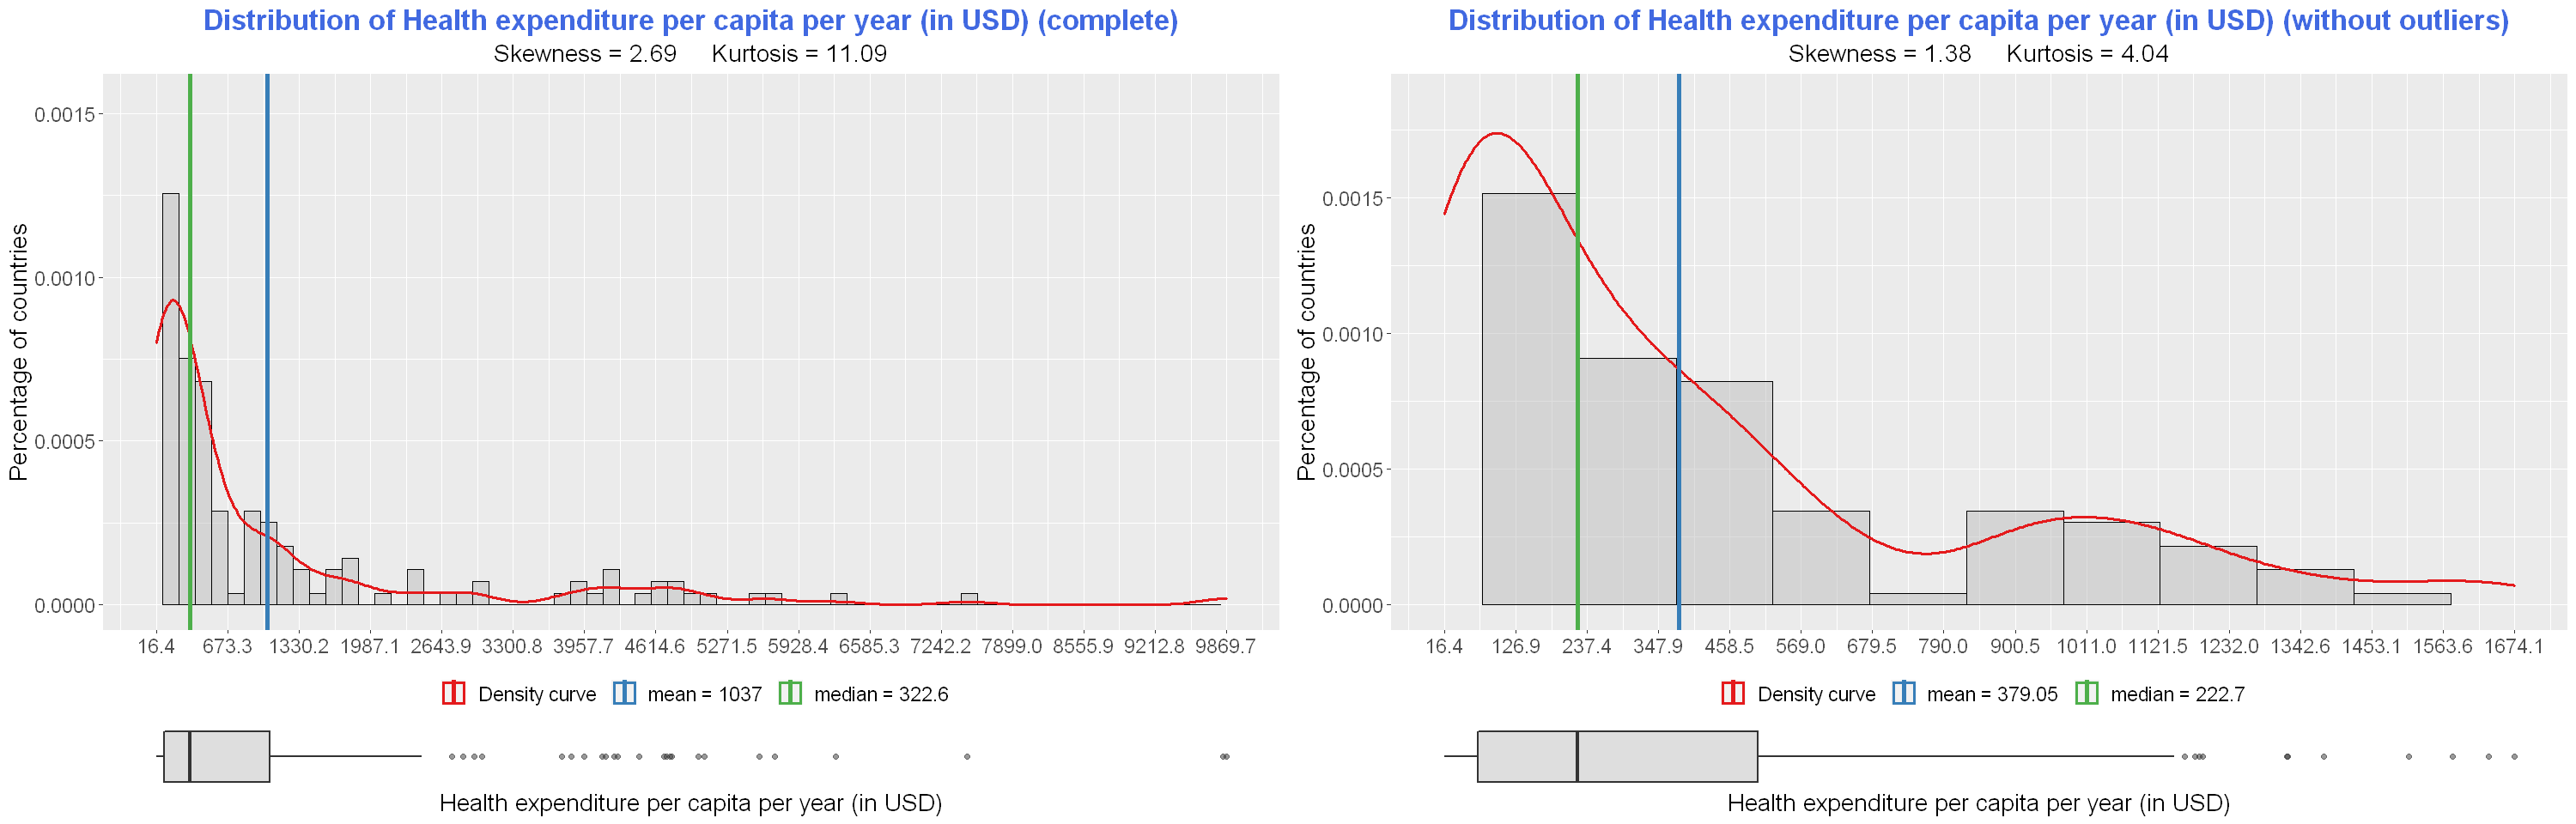

In [14]:
plot_univariate_analysis(imputed_data, col = "Health_exp_percapita_USD", bin_width = 150, var_name = "Health expenditure per capita per year (in USD)", plot.width = 25, plot.height = 8)

For this variable, we have a very different distribution compared to the ones seen so far:
* At first glance, the data is __very skewed__ to the left, meaning that most contries do not spend much money on the health care of the population.
* The skewness is reveled to be high from its value, from the high kurtosis value and from the large distance between the mean and the median.
* Looking at the boxplots the data has a __lot of outliers__, due to its skewness, and even when the outliers are removed, the boxplot still shows a few points that are outside the 75% quantile.
* Even when the outliers are removed, the data is still skewed and uneven, which shows how unbalanced this variable is.
* In conclusion, the skewness to the left that there are a lot more countries that __do not spend money on the healthcare of their citizens__ than countries that do.

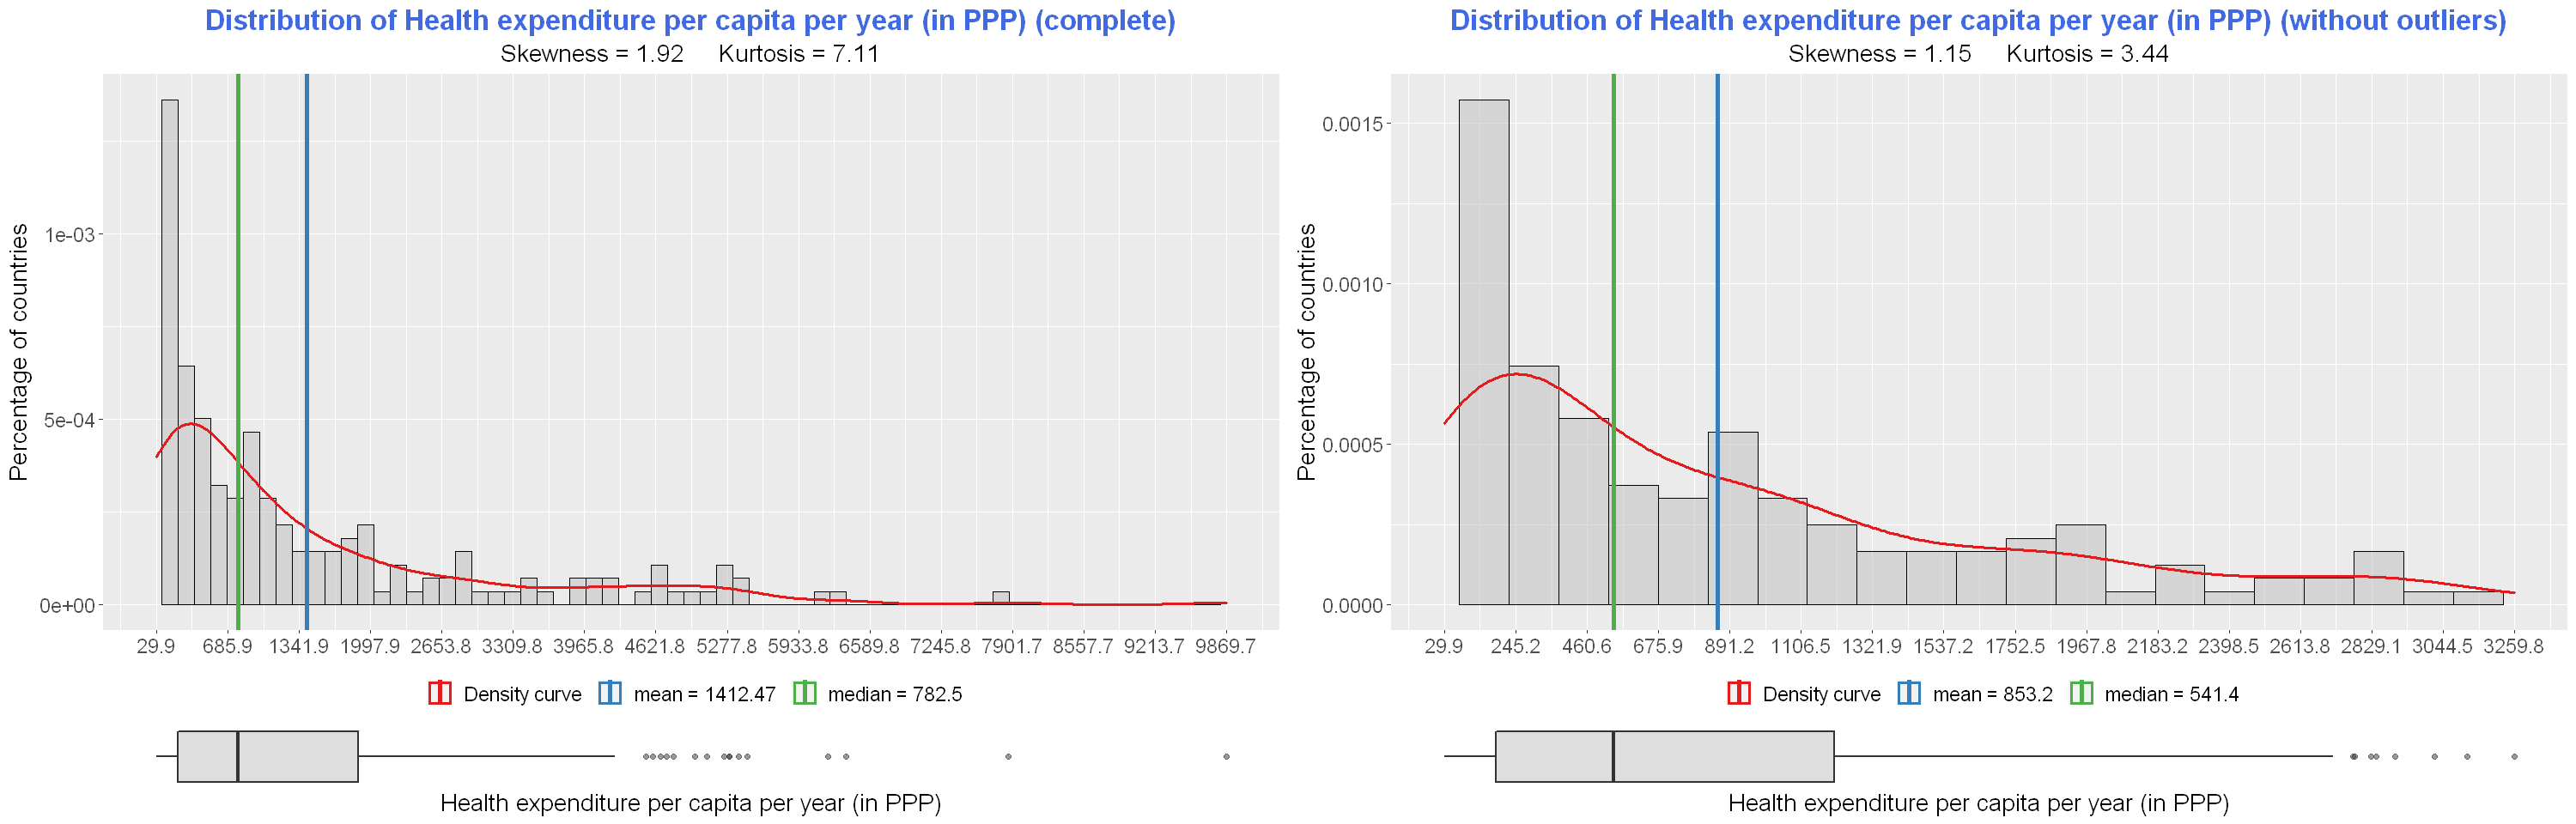

In [15]:
plot_univariate_analysis(imputed_data, col = "Health_exp_percapita_PPP", bin_width = 150, var_name = "Health expenditure per capita per year (in PPP)", plot.width = 25, plot.height = 8)

The distribution of this variable is very similar to the variable above, because they are the __same measure accounted for with different units__, the one above uses USD and this one uses PPP. Therefore, the conclusion that we made for the variable that uses USD are also true for this variable.

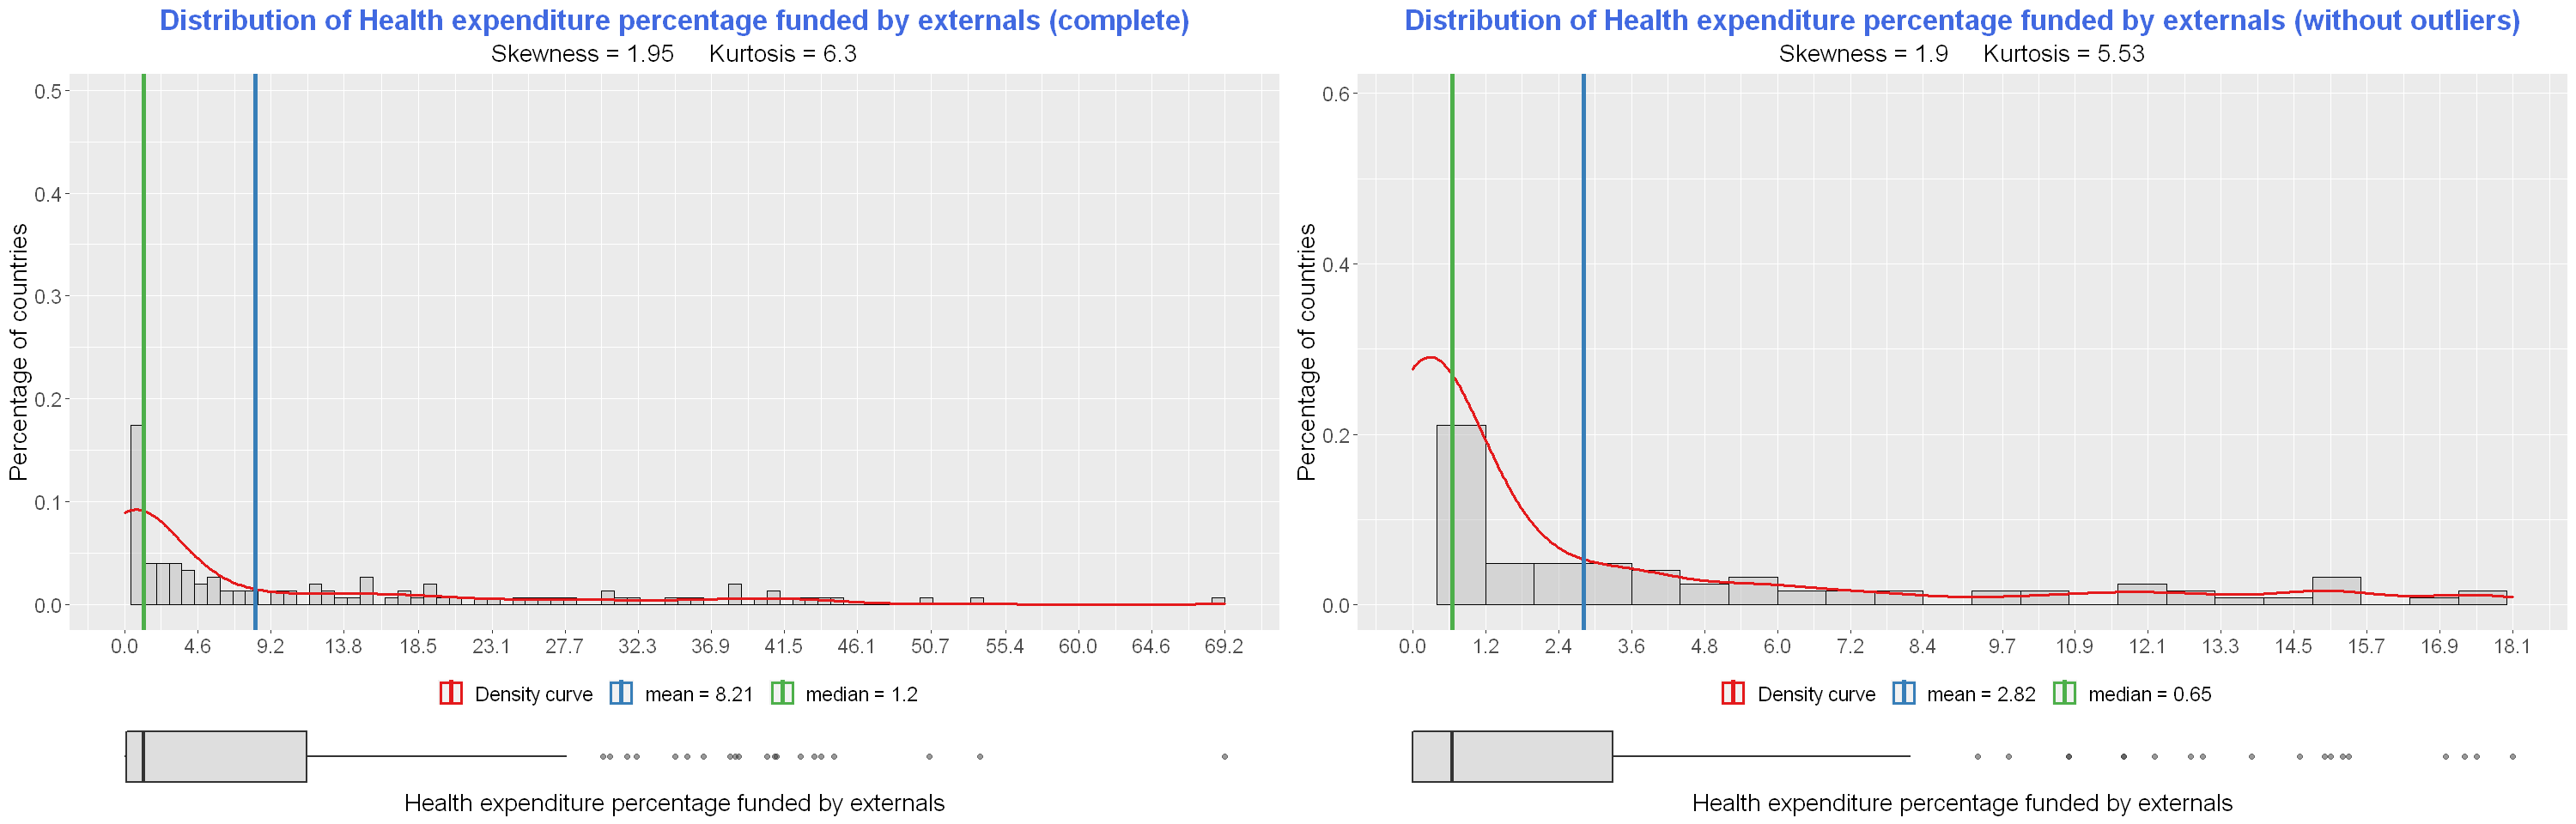

In [16]:
plot_univariate_analysis(imputed_data, col = "Health_exp_pct_funded_by_externals", bin_width = 0.8, var_name = "Health expenditure percentage funded by externals", plot.width = 25, plot.height = 8)

This variable shows a very skewed distribution, with slight differences from the one above:
* Just like the others, the kurtosis, skewness and distance between mean and median show the __uneven distribution__ of this variable.
* The boxplots on both sides show a lot of outliers (even after removing some), further proving that the data is very skewed.
* In conclusion, this skewness can be explained by the fact that a lot of __underdeveloped countries__ have __external helps to pay for healthcare__, while more __developed countries__ are able to __pay for their healthcare themselves__, which creates that skewness to the left.

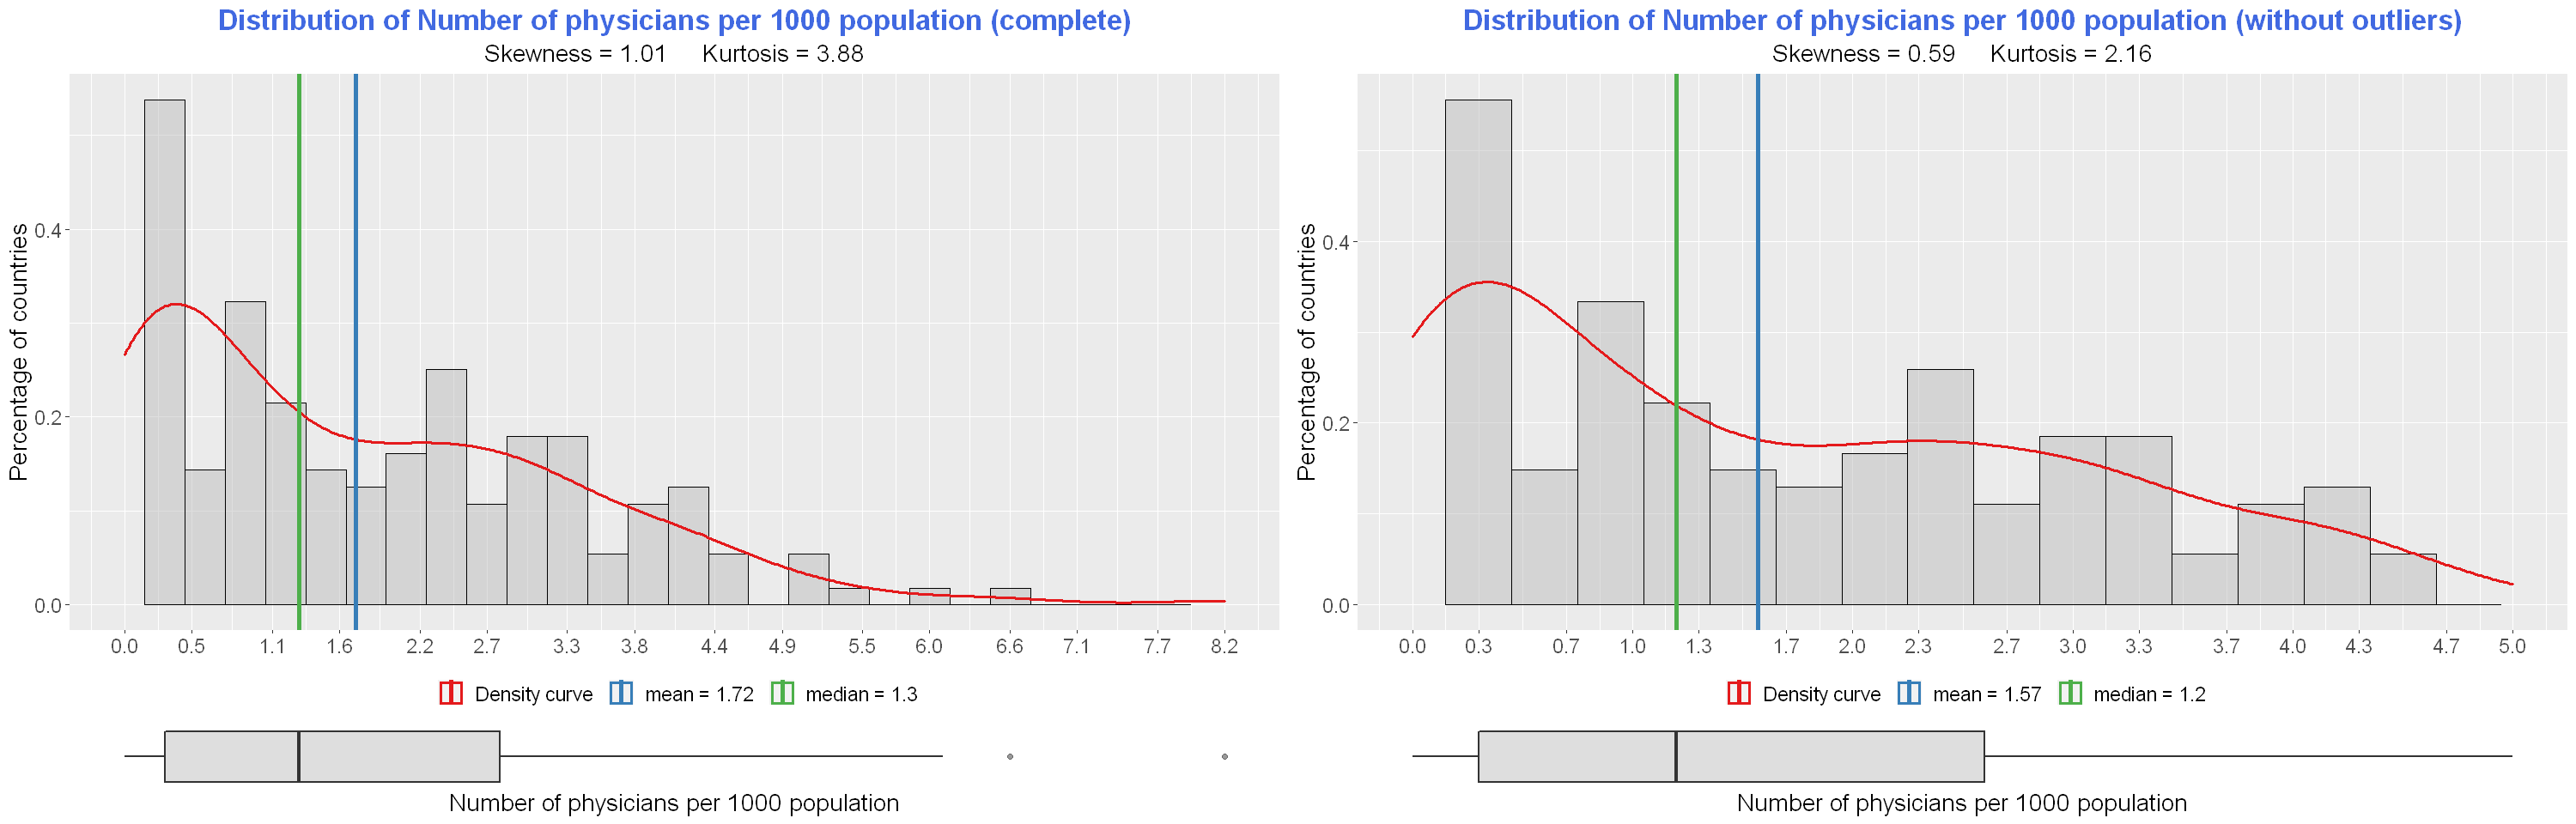

In [17]:
plot_univariate_analysis(imputed_data, col = "Physicians_per_1000", bin_width = 0.3, var_name = "Number of physicians per 1000 population", plot.width = 25, plot.height = 8)

The plot above shows the distribution of physicians per 1000 population in each country:
* Comparing the boxplots and the changes to the mean, median, skewness and kurtosis, we can see that this variable does __not__ contain a __lot of outliers__.
* The complete data is more or less even, however it does show a __slight skewness to the left__, because most poor contries have a lack of qualified doctors.
* In conclusion, underdeveloped countries lack physicians, which causes that large bar at 0 and the skewness of the data.

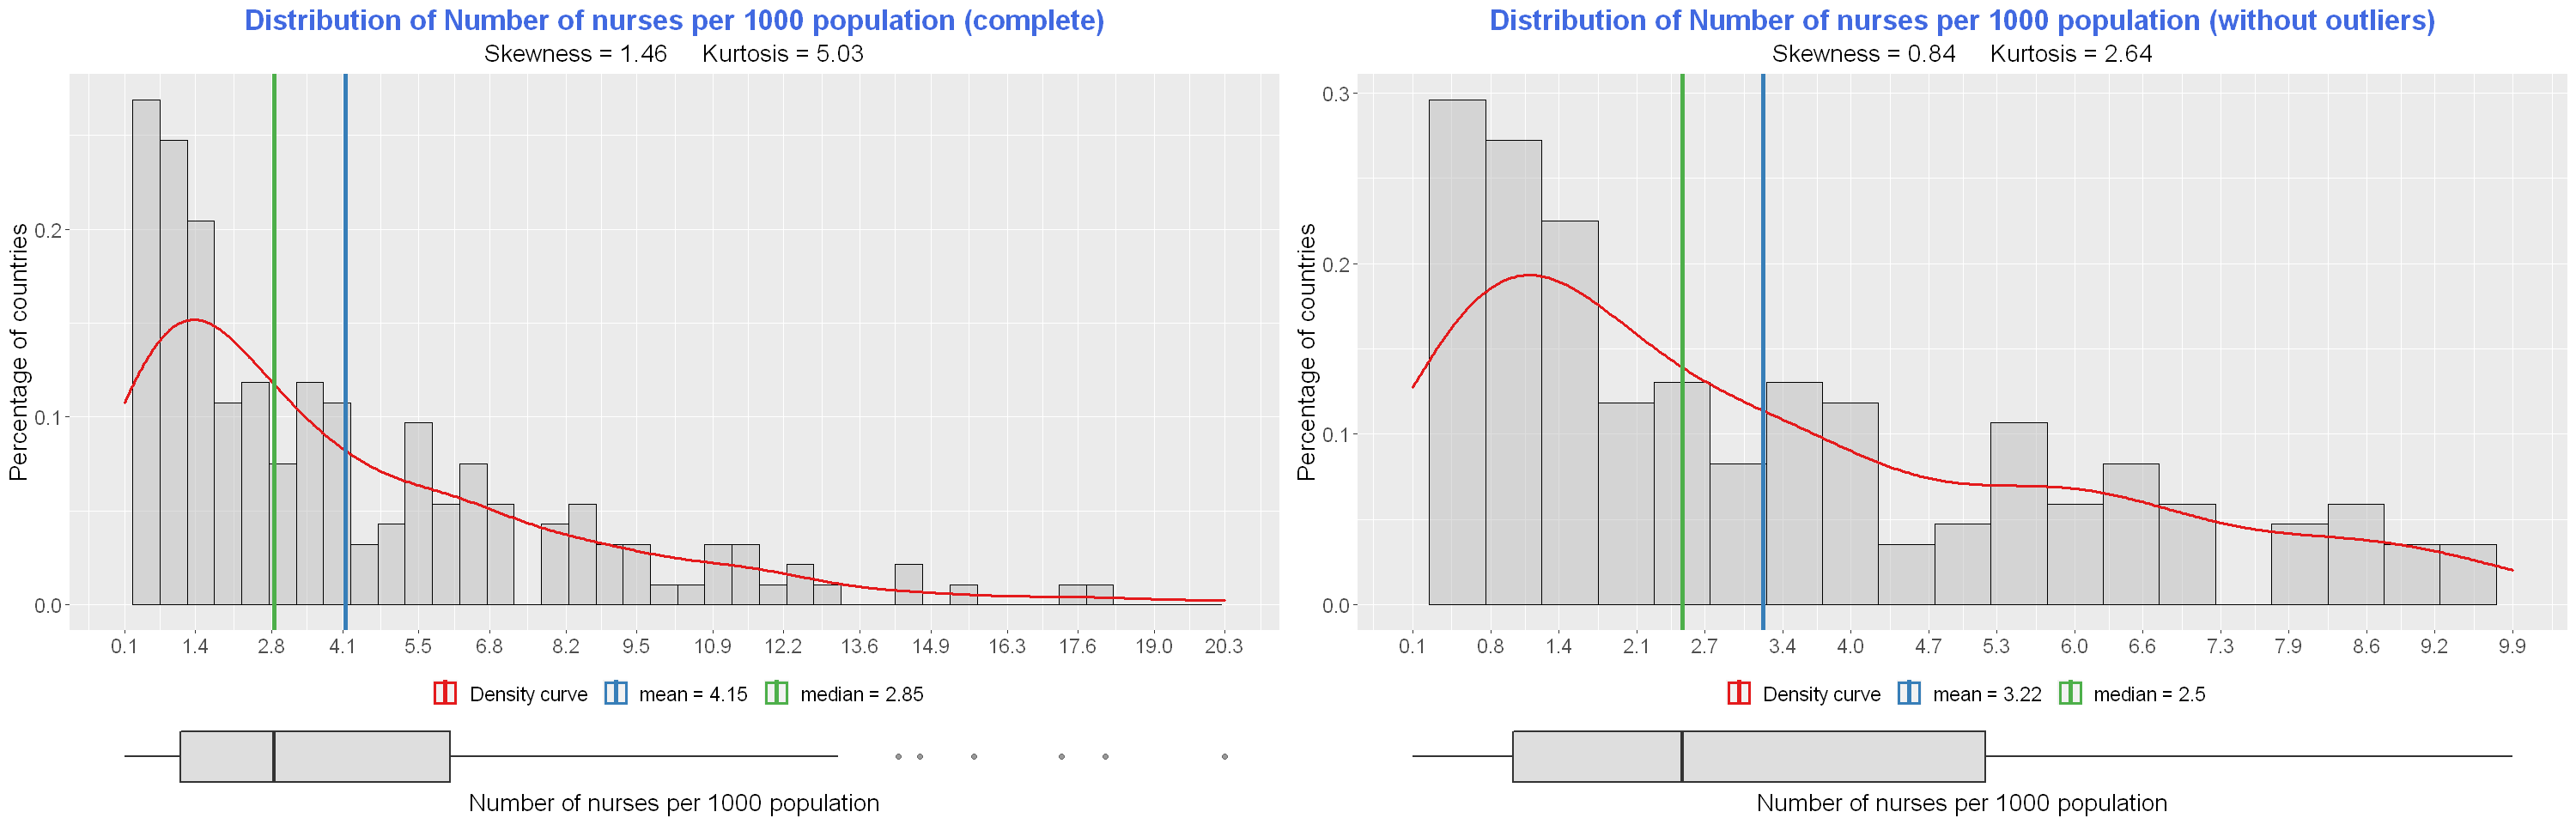

In [18]:
plot_univariate_analysis(imputed_data, col = "Nurses_per_1000", bin_width = 0.5, var_name = "Number of nurses per 1000 population", plot.width = 25, plot.height = 8)

This plots show the distribution of nurses per 1000 population in each country:
* Much like other variables seen before, this one is __very skewed to the left__.
* Countries that have a high number of nurses are viewed as outliers and the plot on the right removes does kinds of countries.
* The changes in the kurtosis and skewness further prove the skewness of the distribution, the kurtosis is reduced by 2.5 and the skewness by 0.6, causing the data with no outliers to be much more evenly distributed.
* In conclusion, just like with the physicians, __underdeveloped countries have a lot less qualified nurses__ than devoloped countries, which is the main reason for skewness in the distribution.

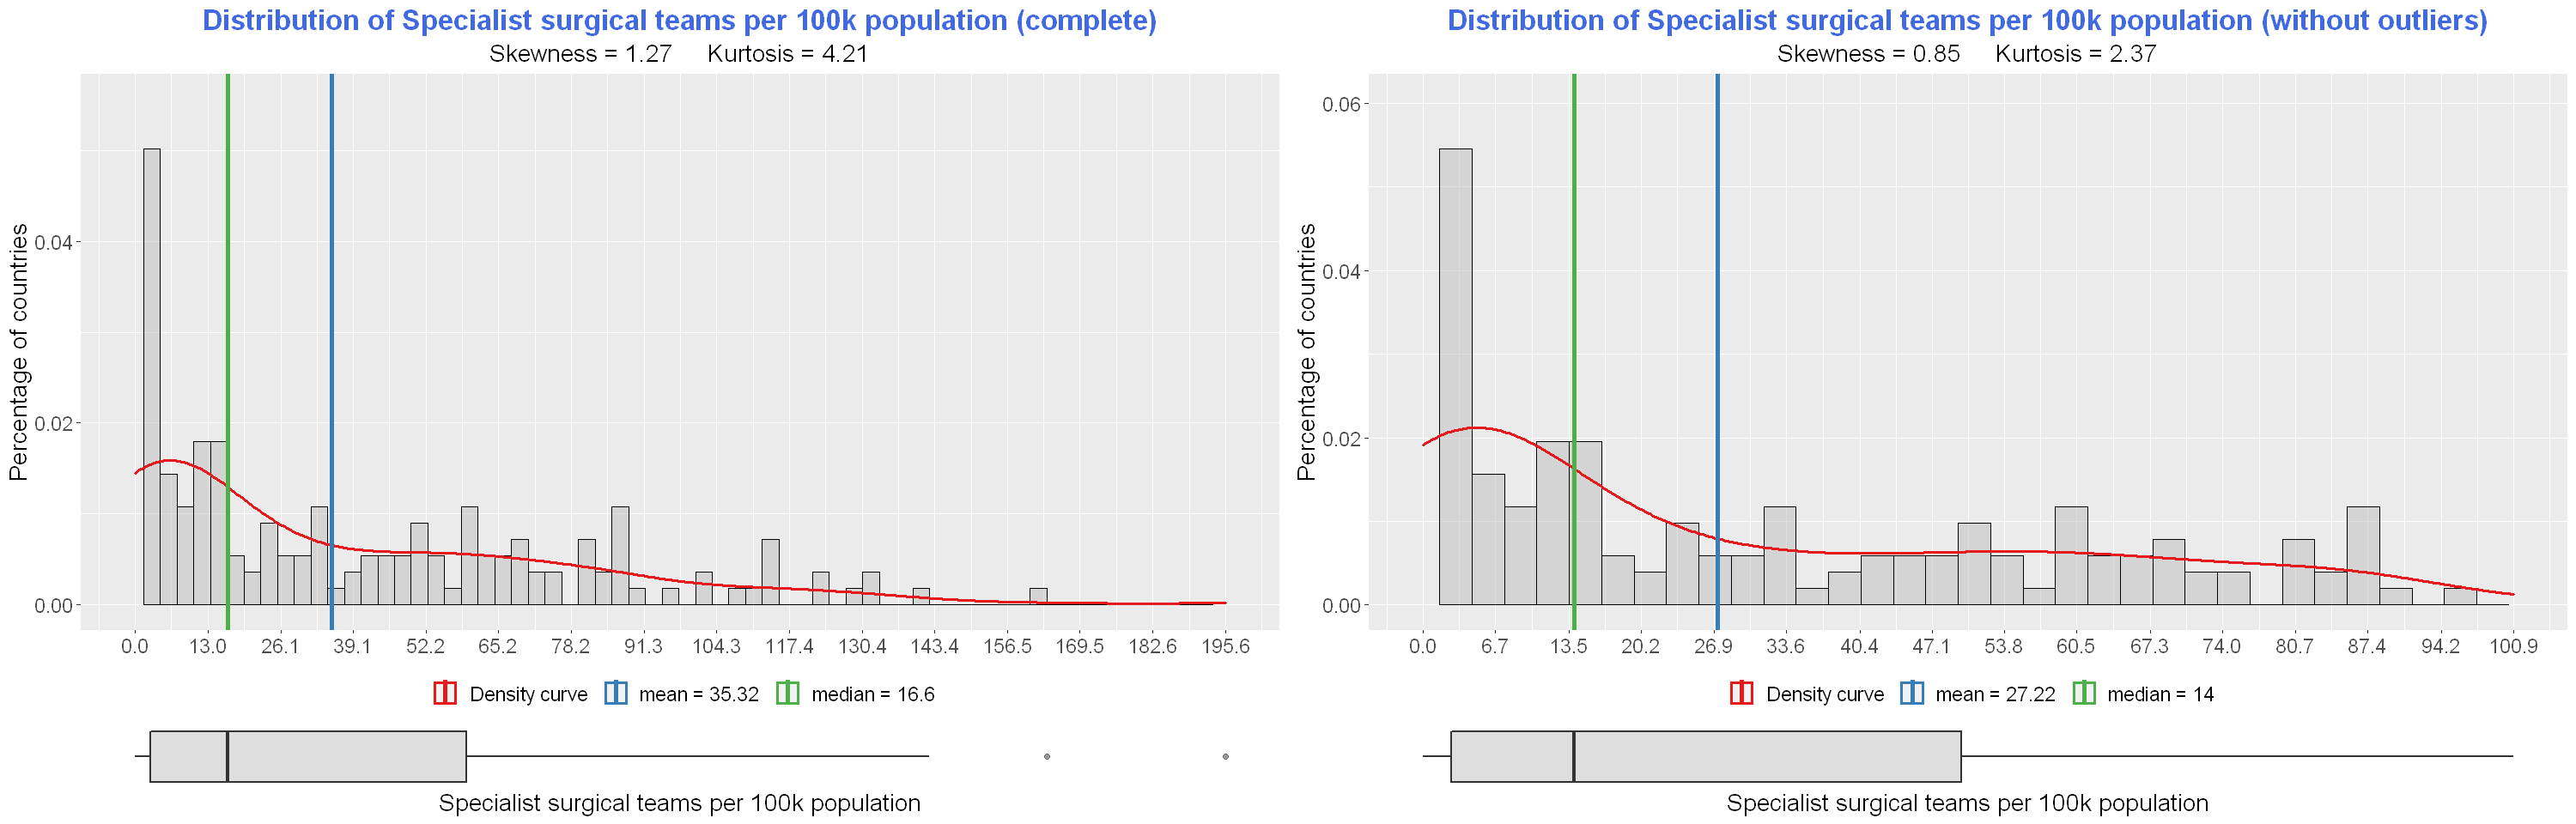

In [19]:
plot_univariate_analysis(imputed_data, col = "Specialist_surgical_per_100000", bin_width = 3, var_name = "Specialist surgical teams per 100k population", plot.width = 25, plot.height = 8)

The distribution of this variables is very similar to the number of physicians per 1000 population, since it also regards medical professionals. The data is __skewed to the left__, because underdeveloped countries do not have possibilities to hire specialist surgical teams, making them the reason for the high bars on the left side of the distribution.

The plot without outliers shows that, there were some countries with a very high number of surgical teams that were also responsible for some skewness, by removing them the distribution becomes a lot more even.

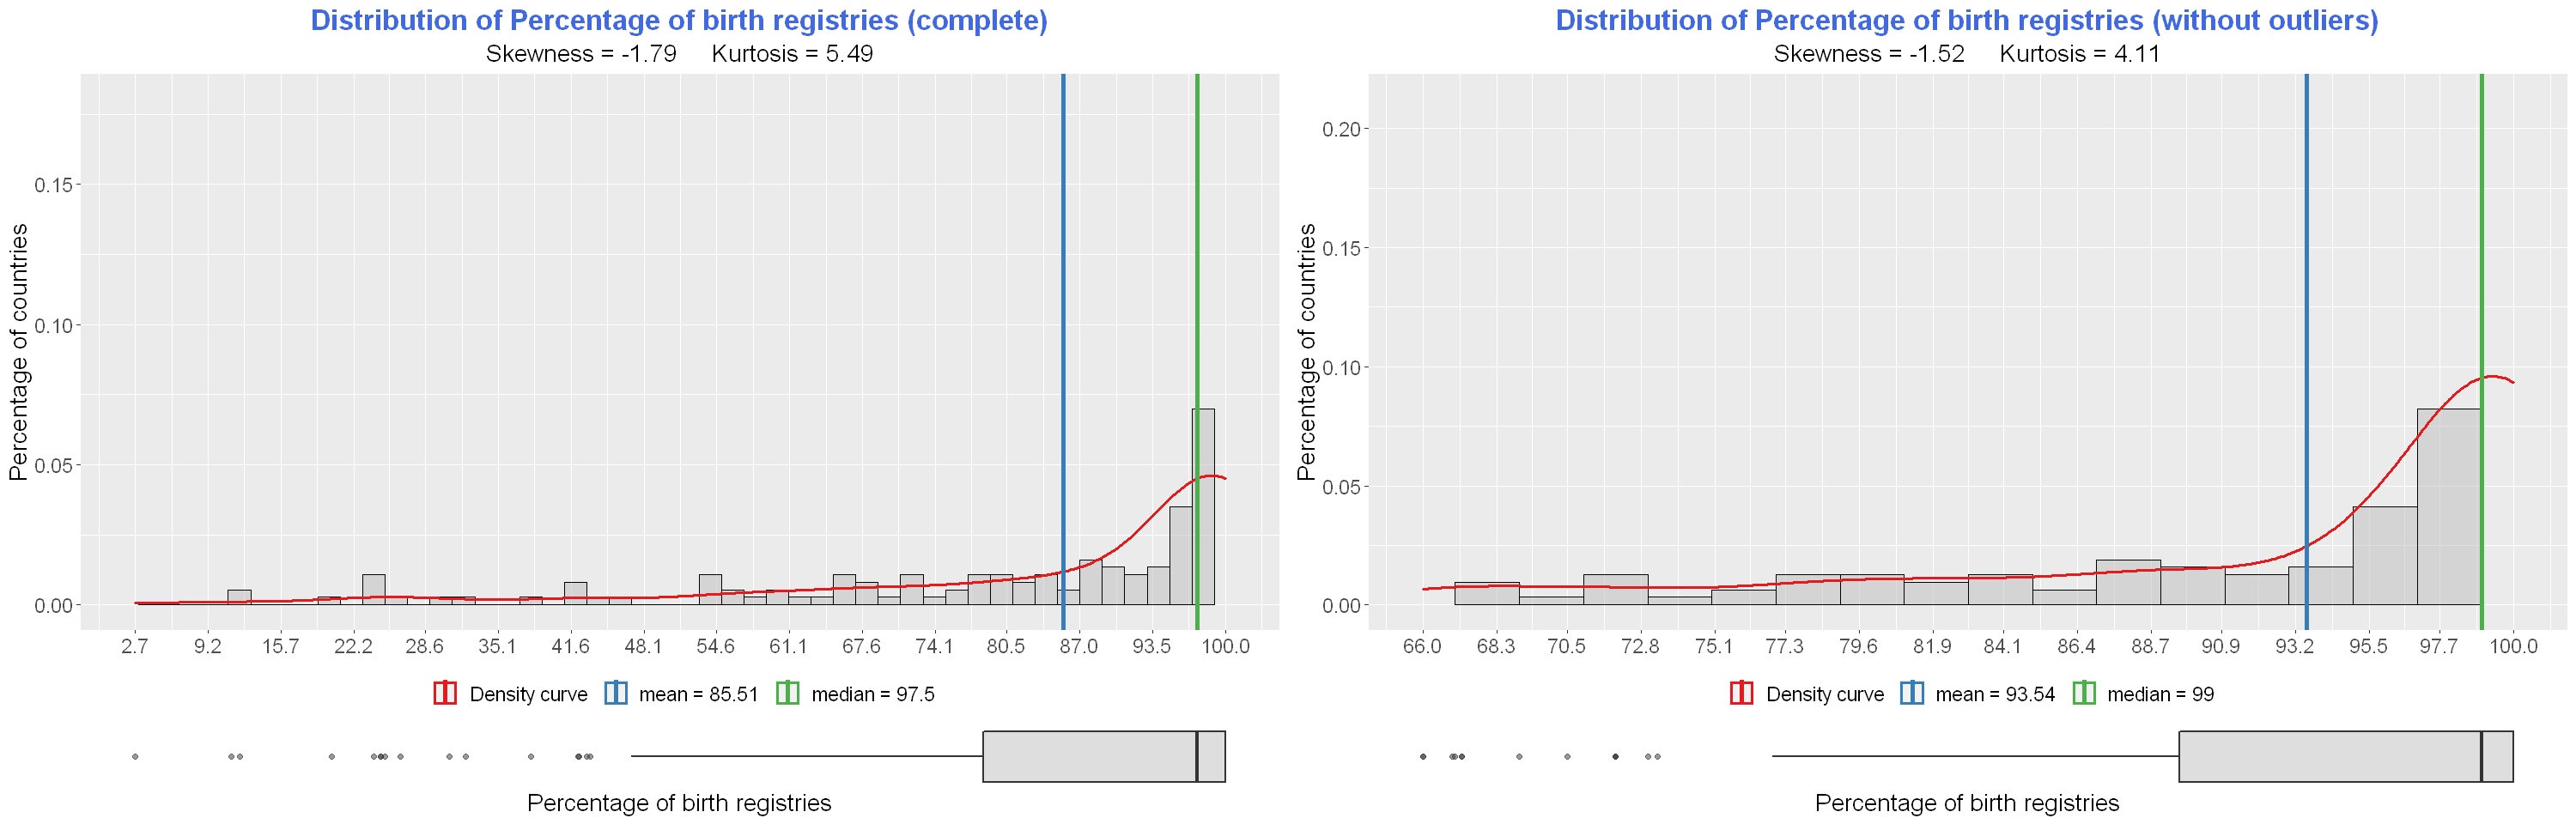

In [20]:
plot_univariate_analysis(imputed_data, col = "Birth_reg_pct", bin_width = 2, var_name = "Percentage of birth registries", plot.width = 25, plot.height = 8)

This variable shows an interesting behaviour, unlike any other explored before:
* Its distribution is __skewed to the right__.
* The outlier values are mostly located in the lower values, which causes the negative skewness.
* Even after removing some outliers, the kurtosis and the skewness are almost unnafected, which means that this distribution is __very unbalanced__.
* In conclusion, __most countries have very complete birth registries__, however, there are a few countries with very low percentages of birth registries, which causes the mean to drop significantly while the median stays high.